In [ ]:
import os
import subprocess
import pandas as pd
import numpy as np
import math
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install skforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.8/424.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.5 MB/s eta 0:00:00


## Models

Time series can be either univariate or multivariate:

>**Univariate** time series only has a single time-dependent variable.

>**Multivariate** time series have a multiple time-dependent variable.

Our example originally is a multivariate time series because its has multiple features that are all time-dependent.


We will evaluate the Mean Absolute Error (MAE) and the Root Mean Square Error (RMSE) of the models. For metrics are better the smaller they are.

> Since our data has multiple features we are going to use multivariate or dependent multi-series forecasting methods

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiSeriesCustom import ForecasterAutoregMultiSeriesCustom
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
# clean_METData = pd.read_csv('../content/drive/My Drive/Colab Notebooks/Drought/clean_METData.csv')
data = clean_METData[['date','T2M_RANGE','T2M_MIN','WS10M_MAX','PRECTOTCORR','SPI']]
data.head()

,date,T2M_RANGE,T2M_MIN,WS10M_MAX,PRECTOTCORR,SPI
0,1991-01-29,-257.431429,14.625429,8.362857,0.530000,0.644588
1,1991-02-05,-257.098571,14.680000,8.398000,0.329714,0.551844
2,1991-02-12,-257.569143,15.220286,8.444000,0.428857,0.554402
3,1991-02-19,-258.402286,16.105714,8.074857,0.562857,0.778456
4,1991-02-26,-257.958571,15.976857,8.043429,0.442571,0.649131


In [ ]:
# Data preparation
# ==============================================================================
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('7D')
data = data.sort_index()
data.head()

,T2M_RANGE,T2M_MIN,WS10M_MAX,PRECTOTCORR,SPI
date,,,,,
1991-01-29,-257.431429,14.625429,8.362857,0.530000,0.644588
1991-02-05,-257.098571,14.680000,8.398000,0.329714,0.551844
1991-02-12,-257.569143,15.220286,8.444000,0.428857,0.554402
1991-02-19,-258.402286,16.105714,8.074857,0.562857,0.778456
1991-02-26,-257.958571,15.976857,8.043429,0.442571,0.649131


In [ ]:
# Split data into train-val-test
# ==============================================================================
end_train = '2020-01-01 '
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}   "
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}   "
    f"(n={len(data_test)})"
)

Train dates : 1991-01-29 00:00:00 --- 2019-12-31 00:00:00   (n=1510)
Test dates  : 2020-01-07 00:00:00 --- 2023-03-28 00:00:00   (n=169)


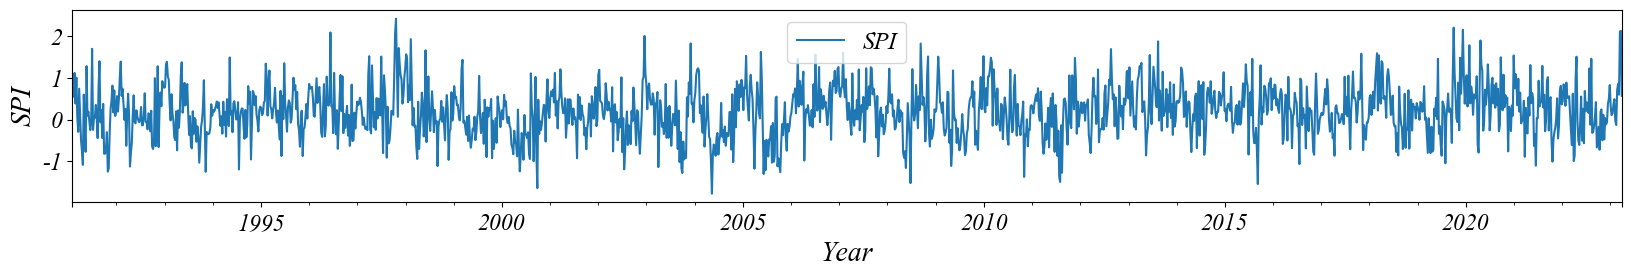

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
rdata['SPI'].plot(ax=ax)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2 )
ax.set_ylabel("SPI",fontdict = font2)
ax.legend(fontsize=17)

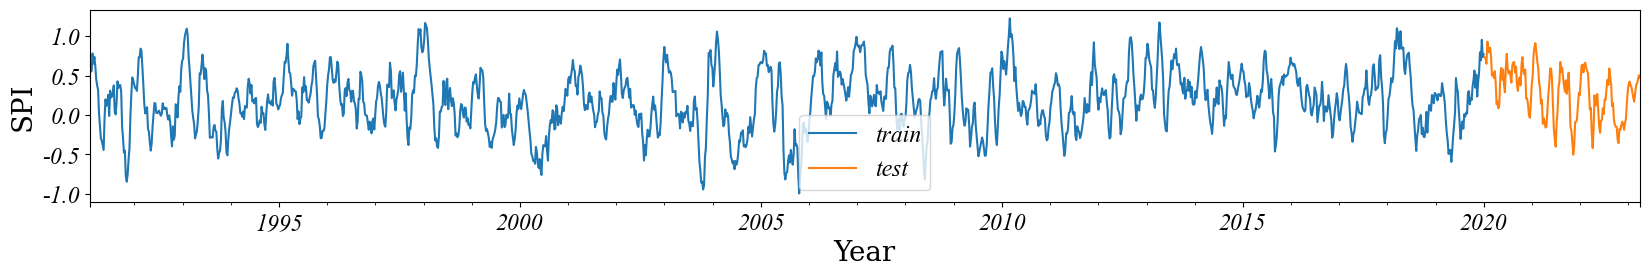

In [ ]:
# Plot
# ==============================================================================
#define font family to use for all text
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.rcParams['font.family'] = 'Times New Roman'

font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['SPI'].plot(ax=ax, label='train')
data_test['SPI'].plot(ax=ax, label='test')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.rcParams['axes.unicode_minus'] = False
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("SPI",fontdict = font2)
ax.legend(fontsize=17);

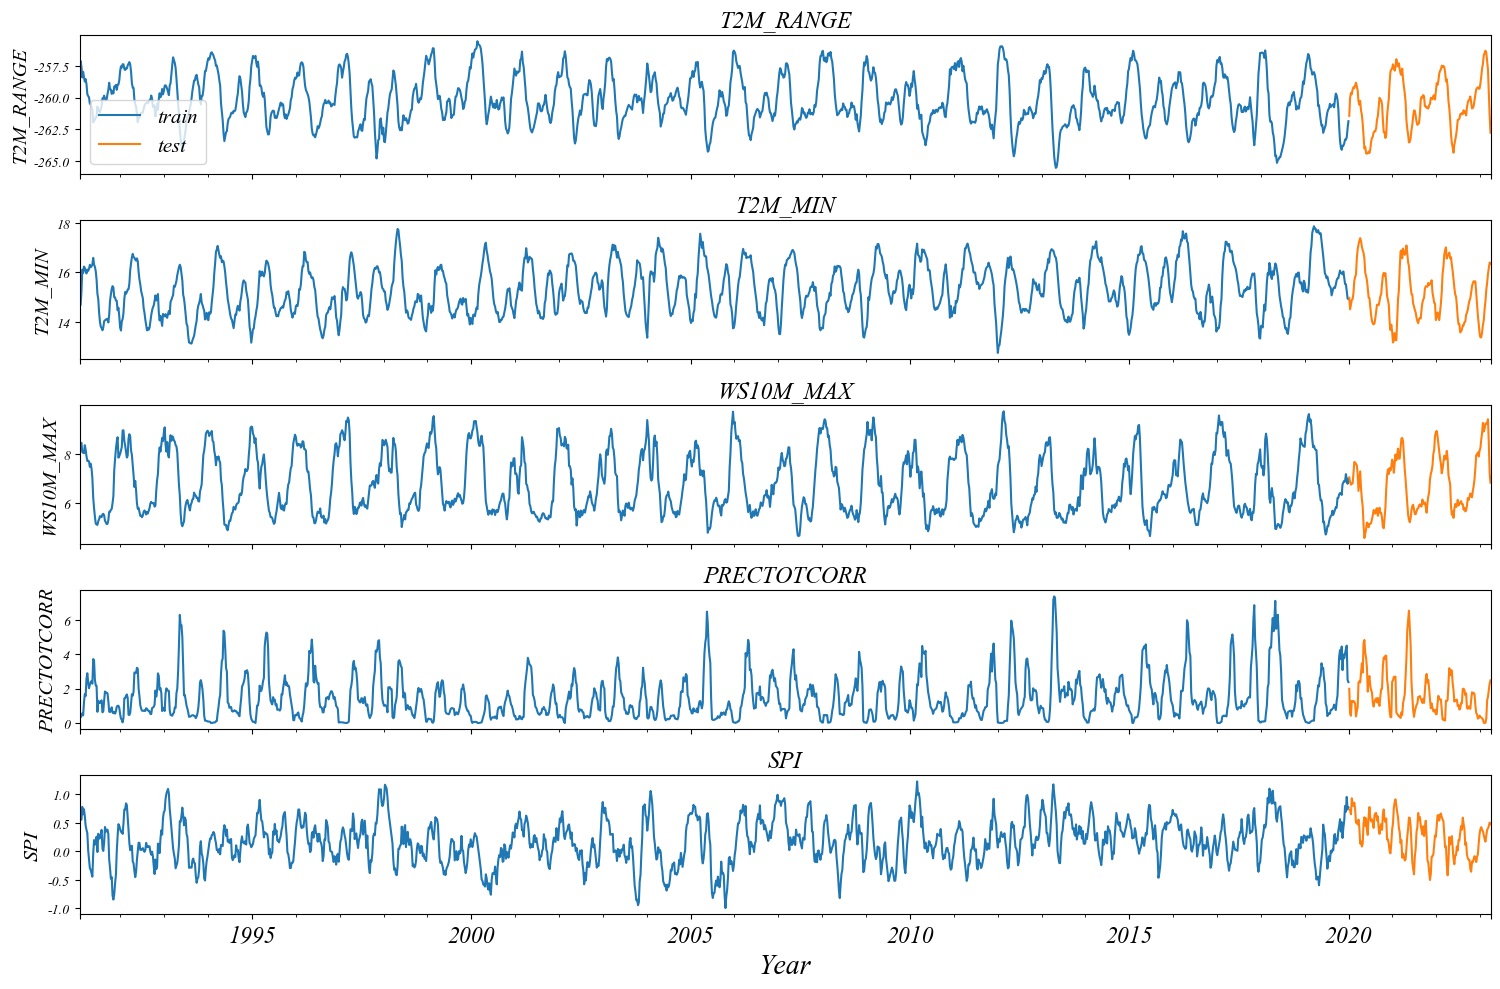

In [ ]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 10), sharex=True)
font2 = {'family':'serif','color':'black','size':20}

data_train['T2M_RANGE'].plot(label='train', ax=axes[0])
data_test['T2M_RANGE'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('Year',fontdict = font2)
axes[0].set_ylabel('T2M_RANGE',fontsize=15)
axes[0].set_title('T2M_RANGE',fontsize=17)
axes[0].legend(fontsize=15)

data_train['T2M_MIN'].plot(label='train', ax=axes[1])
data_test['T2M_MIN'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('Year',fontdict = font2)
axes[1].set_ylabel('T2M_MIN',fontsize=15)
axes[1].set_title('T2M_MIN',fontsize=17)

data_train['WS10M_MAX'].plot(label='train', ax=axes[2])
data_test['WS10M_MAX'].plot(label='test', ax=axes[2])
axes[2].set_xlabel('Year',fontdict = font2)
axes[2].set_ylabel('WS10M_MAX',fontsize=15)
axes[2].set_title('WS10M_MAX',fontsize=17)

data_train['PRECTOTCORR'].plot(label='train', ax=axes[3])
data_test['PRECTOTCORR'].plot(label='test', ax=axes[3])
axes[3].set_xlabel('Year',fontdict = font2)
axes[3].set_ylabel('PRECTOTCORR', fontsize=15)
axes[3].set_title('PRECTOTCORR',fontsize=17)

data_train['SPI'].plot(label='train', ax=axes[4])
data_test['SPI'].plot(label='test', ax=axes[4])
axes[4].set_xlabel('Year',fontdict = font2)
axes[4].set_ylabel('SPI',fontsize=15)
axes[4].set_title('SPI',fontsize=17)
plt.xticks(fontsize=17)
fig.tight_layout()
plt.show();

### Dependent multi-series forecasting (Multivariate forecasting)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.model_selection_multiseries import random_search_forecaster_multiseries

#### CatBoost

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.0 MB/s eta 0:00:00


> Multiseries singel-step

In [ ]:
from catboost import CatBoostRegressor
# Create Forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = CatBoostRegressor(),
                 lags               = 4,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None
             )

In [ ]:
# Grid search Multi Series
# ==============================================================================
lags_grid = [10, 20, 50, 100]
param_grid = {
    'max_depth': [5, 10, 15]
}
levels = ['T2M_RANGE', 'T2M_MIN', 'WS10M_MAX', 'PRECTOTCORR', 'SPI']

results = grid_search_forecaster_multiseries(
              forecaster          = forecaster,
              series              = data,
              exog                = None,
              levels              = levels,
              lags_grid           = lags_grid,
              param_grid          = param_grid,
              steps               = 1,
              metric              = 'mean_absolute_error',
              initial_train_size  = len(data_train),
              refit               = False,
              fixed_train_size    = True,
              return_best         = False,
              verbose             = False
          )

results

6 models compared for 5 level(s). Number of iterations: 6.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
3:	learn: 0.8370319	total: 583ms	remaining: 2m 25s
4:	learn: 0.8029240	total: 682ms	remaining: 2m 15s
5:	learn: 0.7685692	total: 795ms	remaining: 2m 11s
6:	learn: 0.7372358	total: 887ms	remaining: 2m 5s
7:	learn: 0.7073439	total: 1.02s	remaining: 2m 6s
8:	learn: 0.6794218	total: 1.13s	remaining: 2m 4s
9:	learn: 0.6527715	total: 1.24s	remaining: 2m 2s
10:	learn: 0.6265441	total: 1.36s	remaining: 2m 2s
11:	learn: 0.6034228	total: 1.46s	remaining: 2m
12:	learn: 0.5823803	total: 1.57s	remaining: 1m 59s
13:	learn: 0.5619302	total: 1.69s	remaining: 1m 58s
14:	learn: 0.5434955	total: 1.79s	remaining: 1m 57s
15:	learn: 0.5249675	total: 1.91s	remaining: 1m 57s
16:	learn: 0.5084874	total: 2.02s	remaining: 1m 56s
17:	learn: 0.4941211	total: 2.15s	remaining: 1m 57s
18:	learn: 0.4785438	total: 2.27s	remaining: 1m 57s
19:	learn: 0.4645593	total: 2.34s	remaining: 1m 54s
20:	learn: 0.4506949	total: 2.45s	remaining: 1m 54s
21:	learn: 0.4384293	total: 2

,levels,lags,params,mean_absolute_error,max_depth
3,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 5},0.216775,5
0,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 5},0.227720,5
4,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 10},0.242115,10
1,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 10},0.252353,10
2,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 15},0.290989,15
5,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 15},0.293821,15


In [ ]:
results

,levels,lags,params,mean_absolute_error,max_depth
3,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 5},0.216775,5
0,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 5},0.227720,5
4,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 10},0.242115,10
1,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 10},0.252353,10
2,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 15},0.290989,15
5,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 15},0.293821,15


In [ ]:
print(results.lags[3])

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]


In [ ]:
# Create Forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = CatBoostRegressor(max_depth= 5),
                 lags               = 50,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None
             )
forecaster.fit(data_train)

Learning rate set to 0.056051
0:	learn: 0.9576785	total: 57.4ms	remaining: 57.3s
1:	learn: 0.9146647	total: 66.2ms	remaining: 33.1s
2:	learn: 0.8749857	total: 74.8ms	remaining: 24.9s
3:	learn: 0.8371991	total: 83.8ms	remaining: 20.9s
4:	learn: 0.8019986	total: 92.4ms	remaining: 18.4s
5:	learn: 0.7688342	total: 101ms	remaining: 16.7s
6:	learn: 0.7385369	total: 110ms	remaining: 15.6s
7:	learn: 0.7100525	total: 119ms	remaining: 14.8s
8:	learn: 0.6828692	total: 129ms	remaining: 14.2s
9:	learn: 0.6570363	total: 138ms	remaining: 13.6s
10:	learn: 0.6325206	total: 146ms	remaining: 13.1s
11:	learn: 0.6097258	total: 155ms	remaining: 12.8s
12:	learn: 0.5873459	total: 165ms	remaining: 12.6s
13:	learn: 0.5665477	total: 174ms	remaining: 12.3s
14:	learn: 0.5480360	total: 184ms	remaining: 12.1s
15:	learn: 0.5302681	total: 193ms	remaining: 11.9s
16:	learn: 0.5152095	total: 211ms	remaining: 12.2s
17:	learn: 0.4984864	total: 221ms	remaining: 12s
18:	learn: 0.4837693	total: 231ms	remaining: 11.9s
19:	lear

In [ ]:
# Backtesting Multi Series
# ==============================================================================
levels = ['T2M_RANGE', 'T2M_MIN', 'WS10M_MAX', 'PRECTOTCORR', 'SPI']
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster            = forecaster,
                                           series                = data,
                                           levels                = levels,
                                           steps                 = 1,
                                           metric                = ['mean_absolute_error','mean_squared_error', 'mean_absolute_percentage_error'],
                                           initial_train_size    = len(data_train),
                                           fixed_train_size      = True,
                                           gap                   = 0,
                                           allow_incomplete_fold = True,
                                           refit                 = False,
                                           verbose               = False,
                                           show_progress         = True
                                       )

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

Learning rate set to 0.056051
0:	learn: 0.9576785	total: 30.7ms	remaining: 30.7s
1:	learn: 0.9146647	total: 74.5ms	remaining: 37.2s
2:	learn: 0.8749857	total: 88.6ms	remaining: 29.4s
3:	learn: 0.8371991	total: 104ms	remaining: 25.9s
4:	learn: 0.8019986	total: 115ms	remaining: 22.9s
5:	learn: 0.7688342	total: 139ms	remaining: 23s
6:	learn: 0.7385369	total: 150ms	remaining: 21.3s
7:	learn: 0.7100525	total: 165ms	remaining: 20.4s
8:	learn: 0.6828692	total: 178ms	remaining: 19.6s
9:	learn: 0.6570363	total: 194ms	remaining: 19.2s
10:	learn: 0.6325206	total: 204ms	remaining: 18.3s
11:	learn: 0.6097258	total: 233ms	remaining: 19.1s
12:	learn: 0.5873459	total: 244ms	remaining: 18.5s
13:	learn: 0.5665477	total: 258ms	remaining: 18.2s
14:	learn: 0.5480360	total: 292ms	remaining: 19.2s
15:	learn: 0.5302681	total: 327ms	remaining: 20.1s
16:	learn: 0.5152095	total: 370ms	remaining: 21.4s
17:	learn: 0.4984864	total: 407ms	remaining: 22.2s
18:	learn: 0.4837693	total: 438ms	remaining: 22.6s
19:	learn:

  0%|          | 0/169 [00:00<?, ?it/s]

Backtest metrics


,levels,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
0,T2M_RANGE,0.311257,0.155613,0.001195
1,T2M_MIN,0.159047,0.041360,0.010629
2,WS10M_MAX,0.196782,0.061156,0.029102
3,PRECTOTCORR,0.315102,0.204429,0.410004
4,SPI,0.101689,0.016829,1.296649



Backtest predictions


,T2M_RANGE,T2M_MIN,WS10M_MAX,PRECTOTCORR,SPI
2020-01-07,-261.204764,14.921085,7.303698,1.693868,0.619900
2020-01-14,-260.971879,14.971625,7.101650,1.534142,0.726746
2020-01-21,-259.239259,14.497741,7.116451,0.160800,0.560754
2020-01-28,-258.984481,14.788986,7.006311,0.457165,0.611766


In [ ]:
# SPI
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['SPI'],backtest_predictions['SPI'])
mse = mean_squared_error(data_test['SPI'],backtest_predictions['SPI'])
r2 = r2_score(data_test['SPI'],backtest_predictions['SPI'])
rmse = math.sqrt(mean_squared_error(data_test['SPI'],backtest_predictions['SPI']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.10168871750694114
MSE is 0.01682924788605273
RMSE is 0.1297275910747314
R2 is 0.8371939455777836


In [ ]:
#T2M_RANGE
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['T2M_RANGE'],backtest_predictions['T2M_RANGE'])
mse = mean_squared_error(data_test['T2M_RANGE'],backtest_predictions['T2M_RANGE'])
r2 = r2_score(data_test['T2M_RANGE'],backtest_predictions['T2M_RANGE'])
rmse = math.sqrt(mean_squared_error(data_test['T2M_RANGE'],backtest_predictions['T2M_RANGE']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.31125666393192
MSE is 0.15561347817793167
RMSE is 0.3944787423650756
R2 is 0.9616865680278571


In [ ]:
#T2M_MIN
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['T2M_MIN'],backtest_predictions['T2M_MIN'])
mse = mean_squared_error(data_test['T2M_MIN'],backtest_predictions['T2M_MIN'])
r2 = r2_score(data_test['T2M_MIN'],backtest_predictions['T2M_MIN'])
rmse = math.sqrt(mean_squared_error(data_test['T2M_MIN'],backtest_predictions['T2M_MIN']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.15904692756349192
MSE is 0.04136018265690483
RMSE is 0.20337203017353403
R2 is 0.963372646609932


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['WS10M_MAX'],backtest_predictions['WS10M_MAX'])
mse = mean_squared_error(data_test['WS10M_MAX'],backtest_predictions['WS10M_MAX'])
r2 = r2_score(data_test['WS10M_MAX'],backtest_predictions['WS10M_MAX'])
rmse = math.sqrt(mean_squared_error(data_test['WS10M_MAX'],backtest_predictions['WS10M_MAX']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.1967816002750074
MSE is 0.0611555970184883
RMSE is 0.24729657704563623
R2 is 0.9552168793940979


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['PRECTOTCORR'],backtest_predictions['PRECTOTCORR'])
mse = mean_squared_error(data_test['PRECTOTCORR'],backtest_predictions['PRECTOTCORR'])
r2 = r2_score(data_test['PRECTOTCORR'],backtest_predictions['PRECTOTCORR'])
rmse = math.sqrt(mean_squared_error(data_test['PRECTOTCORR'],backtest_predictions['PRECTOTCORR']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.31510188941385014
MSE is 0.20442911174198952
RMSE is 0.4521383767631205
R2 is 0.8616090927645002


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test,backtest_predictions)
mse = mean_squared_error(data_test,backtest_predictions)
r2 = r2_score(data_test,backtest_predictions)
rmse = math.sqrt(mean_squared_error(data_test,backtest_predictions))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.21677515973824213
MSE is 0.0958775234962734
RMSE is 0.3096409590094201
R2 is 0.9158158264748341


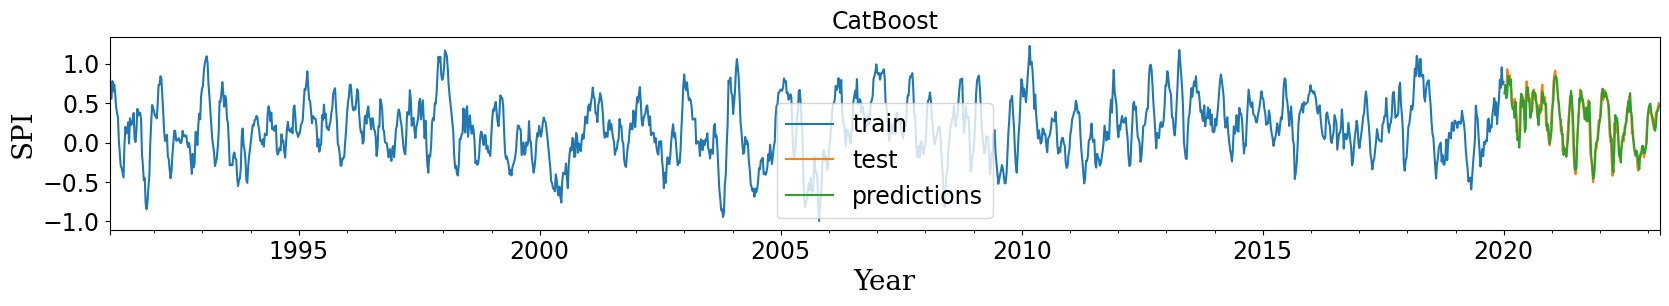

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['SPI'].plot(ax=ax, label='train')
data_test['SPI'].plot(ax=ax, label='test')
backtest_predictions['SPI'].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title(fontsize=17,label='CatBoost')
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("SPI",fontdict = font2)
ax.legend(fontsize=17);

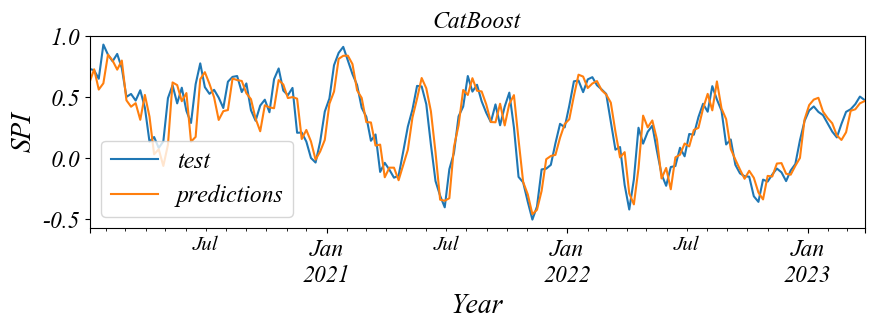

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2.5))
data_test['SPI'].plot(ax=ax, label='test')
backtest_predictions['SPI'].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title(fontsize=17,label='CatBoost')
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("SPI",fontdict = font2)
ax.legend(fontsize=17);

In [ ]:
# Predict
# ==============================================================================
forecaster.fit(data)
predictions = forecaster.predict(steps=300)
predictions.head()

Learning rate set to 0.05703
0:	learn: 0.9566668	total: 26.7ms	remaining: 26.7s
1:	learn: 0.9137176	total: 48.4ms	remaining: 24.2s
2:	learn: 0.8736845	total: 77.7ms	remaining: 25.8s
3:	learn: 0.8357347	total: 115ms	remaining: 28.5s
4:	learn: 0.8008517	total: 135ms	remaining: 27s
5:	learn: 0.7676184	total: 159ms	remaining: 26.4s
6:	learn: 0.7365003	total: 179ms	remaining: 25.4s
7:	learn: 0.7075086	total: 204ms	remaining: 25.3s
8:	learn: 0.6795884	total: 225ms	remaining: 24.7s
9:	learn: 0.6521917	total: 267ms	remaining: 26.4s
10:	learn: 0.6283571	total: 309ms	remaining: 27.8s
11:	learn: 0.6051674	total: 349ms	remaining: 28.7s
12:	learn: 0.5826955	total: 394ms	remaining: 29.9s
13:	learn: 0.5622661	total: 425ms	remaining: 30s
14:	learn: 0.5440182	total: 455ms	remaining: 29.9s
15:	learn: 0.5269910	total: 495ms	remaining: 30.4s
16:	learn: 0.5100741	total: 538ms	remaining: 31.1s
17:	learn: 0.4933094	total: 590ms	remaining: 32.2s
18:	learn: 0.4784974	total: 626ms	remaining: 32.3s
19:	learn: 0.

,T2M_RANGE,T2M_MIN,WS10M_MAX,PRECTOTCORR,SPI
2023-04-04,-263.043706,16.402595,6.287876,2.210266,0.404376
2023-04-11,-263.204194,16.410789,5.847528,2.446577,0.368783
2023-04-18,-263.251289,16.366251,5.654309,2.515630,0.296806
2023-04-25,-263.094546,16.344176,5.680626,2.506696,0.231761
2023-05-02,-263.057559,16.344211,5.625755,2.430909,0.191311


In [ ]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=300)
predictions.head()

,T2M_RANGE,T2M_MIN,WS10M_MAX,PRECTOTCORR,SPI
2023-04-04,-263.043706,16.402595,6.287876,2.210266,0.404376
2023-04-11,-263.204194,16.410789,5.847528,2.446577,0.368783
2023-04-18,-263.251289,16.366251,5.654309,2.515630,0.296806
2023-04-25,-263.094546,16.344176,5.680626,2.506696,0.231761
2023-05-02,-263.057559,16.344211,5.625755,2.430909,0.191311


In [ ]:
predictions.tail(3)

,T2M_RANGE,T2M_MIN,WS10M_MAX,PRECTOTCORR,SPI
2028-12-12,-257.741467,15.281439,7.169081,0.276295,-0.103494
2028-12-19,-257.543026,15.346546,7.399218,0.206258,-0.088085
2028-12-26,-257.505372,15.390320,7.655593,0.185722,-0.062391


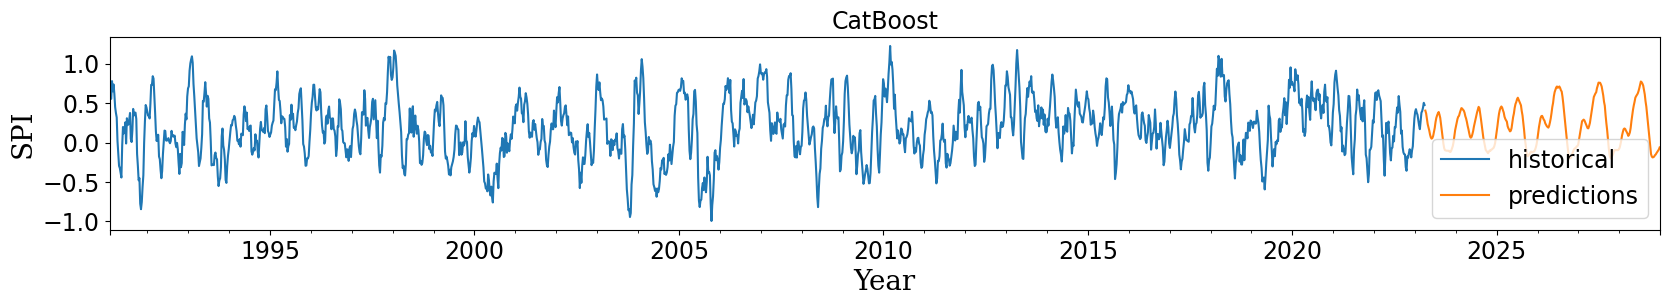

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data['SPI'].plot(ax=ax, label='historical')
predictions['SPI'].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title(fontsize=17,label='CatBoost')
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("SPI",fontdict = font2)
ax.legend(fontsize=17);

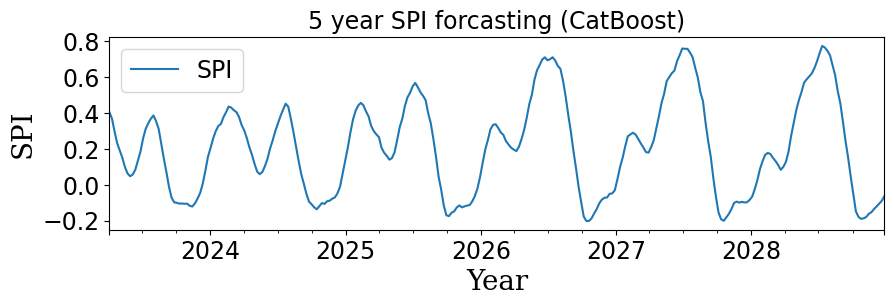

In [ ]:
# Plot
# ==============================================================================
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2.5))
predictions['SPI'].plot(ax=ax)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title(fontsize=17,label='5 year SPI forcasting (CatBoost)')
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("SPI",fontdict = font2)
ax.legend(fontsize=17);